In [2]:
#install.packages("tidyr")
#install.packages("ggfortify")
#install.packages("ggrepel")
#install.packages("BiocManager")
#install.packages("WebGestaltR")
#Sys.setenv(R_INSTALL_STAGED = FALSE)
#BiocManager::install("DESeq2")
#BiocManager::install("cowplot")

In [9]:
library(tidyr)
library(DESeq2)
library(ggplot2)
library(reshape2)
library(dplyr)
library(Rtsne)
library(caret)
library(ggfortify)
library(ggrepel)
library(WebGestaltR)
library(RCurl)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min



Attaching package: ‘S4Vectors’


The

In [2]:
preparePCAplots = function(pca, metadata_of_interest){

    data_to_plot <- cbind(data.frame(PC1 = pca$x[,1], PC2 = pca$x[,2]), metadata_of_interest)
    features_to_plot <- setdiff(colnames(data_to_plot), c("PC1", "PC2"))
    features_to_plot <- setNames(features_to_plot, features_to_plot)
    all_plots_pca <- lapply(features_to_plot,
           function(col) {
                        gg = ggplot(data = data_to_plot) +
                        geom_point(aes(x = PC1, y = PC2, color = !!sym(col)), size = 5) +
                        theme(legend.position = "bottom", legend.margin=margin(t=0, unit="pt"),  
                              text = element_text(size=14), 
                              legend.title = element_text(size = 10),
                        legend.text = element_text(size = 10)) + xlab("") + ylab("") # xlim(-5,5) + ylim(-5,5)+ 
                        if (class(data_to_plot[,col]) == "factor")
                        gg = gg + guides(colour = guide_legend(title.position = "top", nrow = 2))
                        if (class(data_to_plot[,col]) == "character")
                        gg = gg + guides(colour = guide_legend(title.position = "top", nrow = 3))
                          
           return(gg)}
    )
    return(all_plots_pca)
}

In [3]:
inputfolder = "~/Pathonoia/OUTPUT/PSC/"
ds = "kfo_kiel_60_liver_patients"

# fibrosis mRNA

In [4]:
pca_outlier = c()

In [12]:
counts = read.table(paste0(inputfolder,ds,"_contamination_aggregated.csv"), sep = ",", header=TRUE, check.names = FALSE, row.names = "")

if(exists("pca_outlier")){
    print(pca_outlier)
    counts = counts[,!(colnames(counts) %in% pca_outlier)]
} else {
    pca_outlier = c()
}

pathoInfoCols = c("species_name","phylo_level","parent")
pathoInfo = counts[pathoInfoCols]
counts = counts[,!colnames(counts) %in% pathoInfoCols]

counts[is.na(counts)]=0
#counts

 [1] "F12271" "F12285" "F12332" "F12289" "F12292" "F12278" "F12324" "F12293"
 [9] "F12277" "F12317" "F12269" "F12253"


In [13]:
numberOfZerosAllowed = length(counts)*0.99
counts_lessSparse = counts[!(rowSums(counts == 0) > numberOfZerosAllowed),]
table(duplicated(counts_lessSparse))
counts = counts_lessSparse

metadata = read.table(paste0(inputfolder,"KFO60_metadata.csv"), sep=",", header=TRUE)
rownames(metadata) = metadata$sample
metadata = metadata[colnames(counts),]
metadata$fibrosis = gsub('1-2', '1.5', metadata$fibrosis)
metadata$fibrosis = gsub('0-1', '0.5', metadata$fibrosis)
metadata$fibrosis = gsub('2-3', '0.5', metadata$fibrosis)
metadata$fibrosis = as.numeric(metadata$"fibrosis")
cols_of_interest = c("sex",'age','diagnosis','fibrosis','mHAI')
metadata_of_interest = metadata[rownames(t(counts)),cols_of_interest]
metadata_of_interest = cbind(metadata_of_interest,t(counts["43768",rownames(metadata_of_interest)]))
metadata_of_interest = cbind(metadata_of_interest,t(counts["1858609",rownames(metadata_of_interest)]))
metadata_of_interest


FALSE  TRUE 
  651     2 

,sex,age,diagnosis,fibrosis,mHAI,43768,1858609
,<int>,<int>,<fct>,<dbl>,<int>,<dbl>,<dbl>
F12246,2,41,PBC,1.0,2,0,0
F12247,1,30,PSC,2.0,4,644,0
F12248,2,56,AIH,1.0,7,0,0
F12249,2,53,AIH,2.0,12,0,0
F12250,1,44,PSC,2.0,2,770,0
F12252,2,23,NASH,1.0,NA,0,0
F12254,1,40,PBC,0.0,4,0,0
F12255,1,24,PSC,3.0,NA,0,0
F12257,1,31,PSC,1.0,1,790,0


# PCA and TSNE

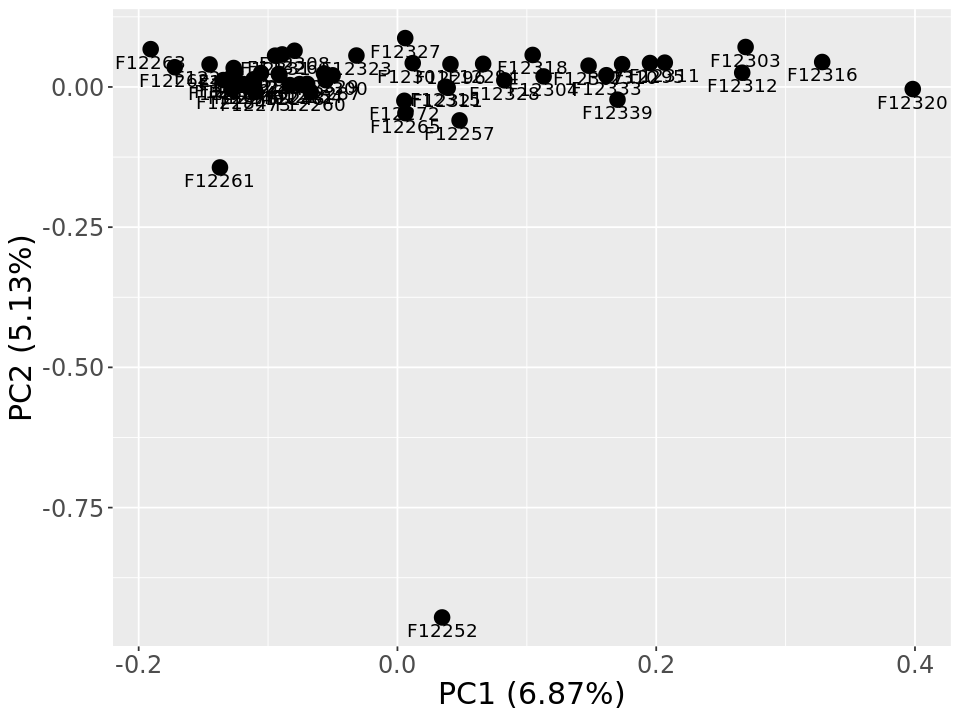

In [14]:
pca <- prcomp(t(counts), scale = TRUE)
options(repr.plot.width=8, repr.plot.height=6)
autoplot(pca, label = TRUE, size = 4, label.vjust = 1.5) + theme(text = element_text(size=18))
all_plots_pca = preparePCAplots(pca,metadata_of_interest)

In [22]:
pca_outlier = c('F12271','F12285','F12332', 'F12289', 'F12292', 'F12278', 'F12324', 'F12293', 'F12277', 'F12317', 'F12269', 'F12253')#, 'F12252')
#pca_outlier = c()

# re-run cells from above after this

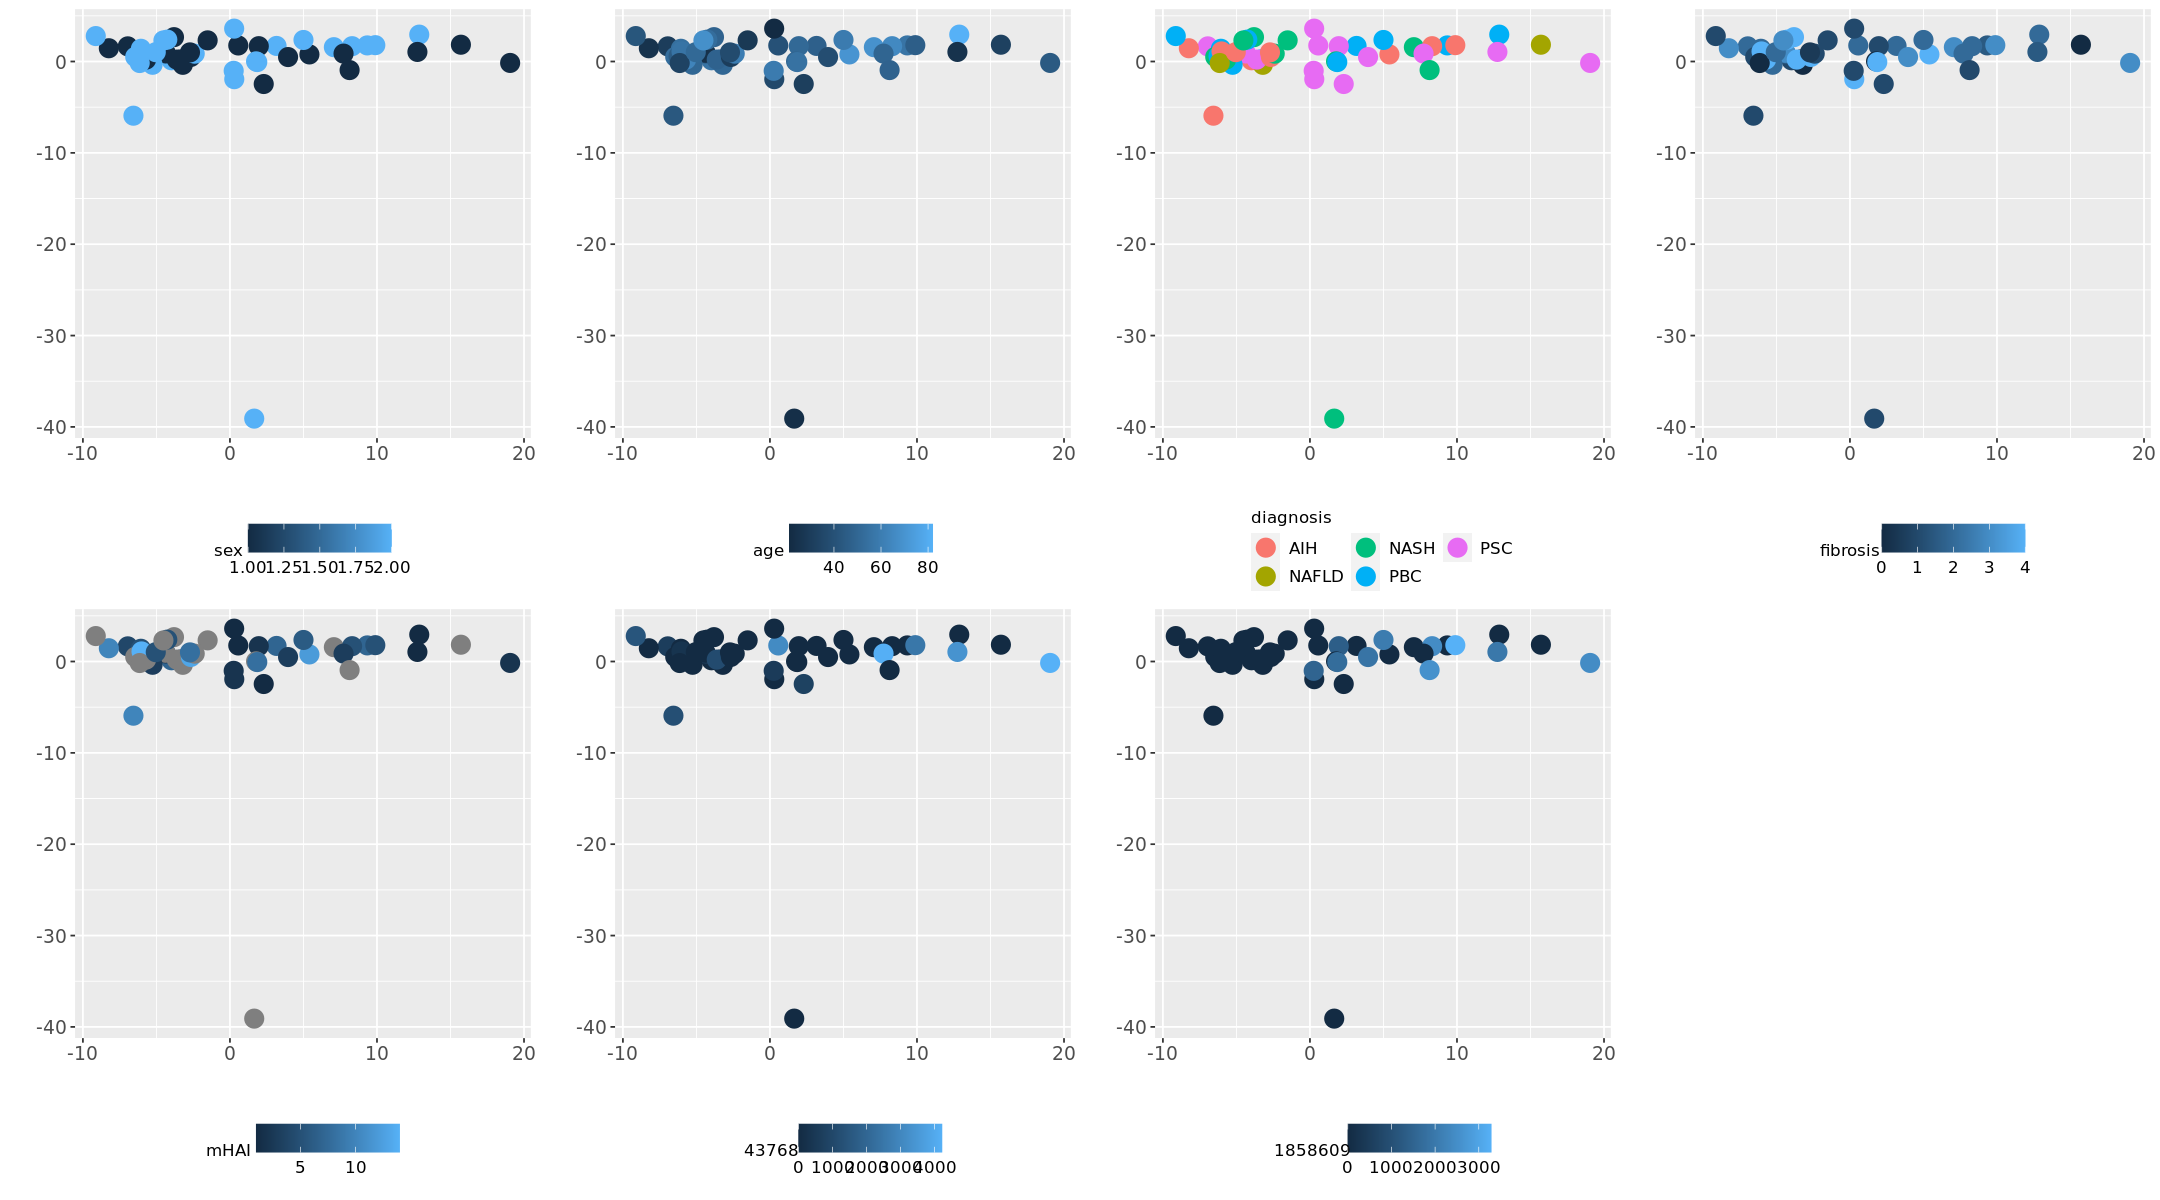

In [15]:
options(repr.plot.width=18, repr.plot.height=10)
cowplot::plot_grid(plotlist = all_plots_pca, ncol = 4, align = "h") 

# Differential Expression

In [16]:
metadata$DE_GROUP = metadata$fibrosis < 1
metadata

,pseudonym,sex,birthdate,age,date.bx,diagnosis,fibrosis,mHAI,Interface,confluent.Necrosis,⋯,UDCA.bx,Mesalazin.bx,hepatic.decompensation.ever,Cholestase.stenosis.ever.MRT,Cholangitiden.clinical.ever,Pfortaderthrombose.ever,GB.carcinoma,date.GBC,Nachverfolgung.bis,DE_GROUP
,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<dbl>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<lgl>
F12246,DAQHBO,2,20.06.1971,41,18.02.2013,PBC,1.0,2,0,0,⋯,NA,NA,NA,NA,NA,NA,NA,,,FALSE
F12247,KSMTKO,1,15.10.1984,30,10.12.2014,PSC,2.0,4,1,0,⋯,0,0,0,1,0,0,0,NA,01/01/2015,FALSE
F12248,KQGQJN,2,15.12.1956,56,29.11.2013,AIH,1.0,7,1,1,⋯,NA,NA,NA,NA,NA,NA,NA,,,FALSE
F12249,FLYJDY,2,15.09.1961,53,10.06.2015,AIH,2.0,12,4,1,⋯,NA,NA,NA,NA,NA,NA,NA,,,FALSE
F12250,NPLQMM,1,15.10.1970,44,07.01.2015,PSC,2.0,2,0,0,⋯,0,0,0,1,0,0,0,NA,01/01/2016,FALSE
F12252,JHJNIE,2,15.11.1991,23,26.10.2015,NASH,1.0,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,,,FALSE
F12254,SQMDQN,1,15.10.1973,40,29.11.2013,PBC,0.0,4,1,0,⋯,NA,NA,NA,NA,NA,NA,NA,,,TRUE
F12255,POGCDG,1,15.09.1990,24,27.03.2015,PSC,3.0,NA,NA,NA,⋯,1000,0,0,1,0,0,0,NA,01/01/2016,FALSE
F12257,SHLELG,1,15.07.1980,31,12.10.2011,PSC,1.0,1,0,0,⋯,0,0,0,0,0,0,0,NA,01/01/2012,FALSE


In [17]:
dds <- DESeqDataSetFromMatrix(countData = counts[,rownames(metadata)],
                              colData = metadata,
                              design= ~ DE_GROUP)
dds <- DESeq(dds)
resultsNames(dds) 

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 495 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"    "DE_GROUPTRUE"

In [18]:
deres = as.data.frame(results(dds, name=resultsNames(dds)[2]))
r = cbind(pathoInfo[rownames(deres),pathoInfoCols],deres)
r = r[r$padj<0.05 & !is.na(r$padj),]
r = r[order(r$padj),]
r

,species_name,phylo_level,parent,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
43768,Corynebacterium matruchotii,S,1716,426.40649,-26.43545,3.348853,-7.893883,2.929267e-15,2.929267e-13
1858609,Acidovorax sp. T1,S,2684926,340.59224,-29.98269,3.794328,-7.901975,2.745174e-15,2.929267e-13
71999,Kocuria palustris,S,57493,98.11371,-24.42146,3.304675,-7.389971,1.468604e-13,9.790692e-12
28037,Streptococcus mitis,S,1301,644.29336,-27.84560,3.878106,-7.180206,6.960624e-13,3.480312e-11
2014534,Microbacterium sp. PM5,S,2609290,117.95997,-24.62277,3.487629,-7.060032,1.664649e-12,6.658595e-11
1114967,Cutibacterium acnes TypeIA2 P.acn17,S2,1734925,4480.34937,-29.65474,4.262719,-6.956766,3.481717e-12,9.035843e-11
1211579,Pseudomonas putida NBRC 14164,S1,303,888.66320,-27.40353,3.923167,-6.985054,2.847462e-12,9.035843e-11
1499308,Paracoccus mutanolyticus,S,265,170.86412,-24.68952,3.551684,-6.951496,3.614337e-12,9.035843e-11
440085,Methylorubrum extorquens CM4,S1,408,286.29685,-29.33461,4.262734,-6.881641,5.916685e-12,1.311916e-10


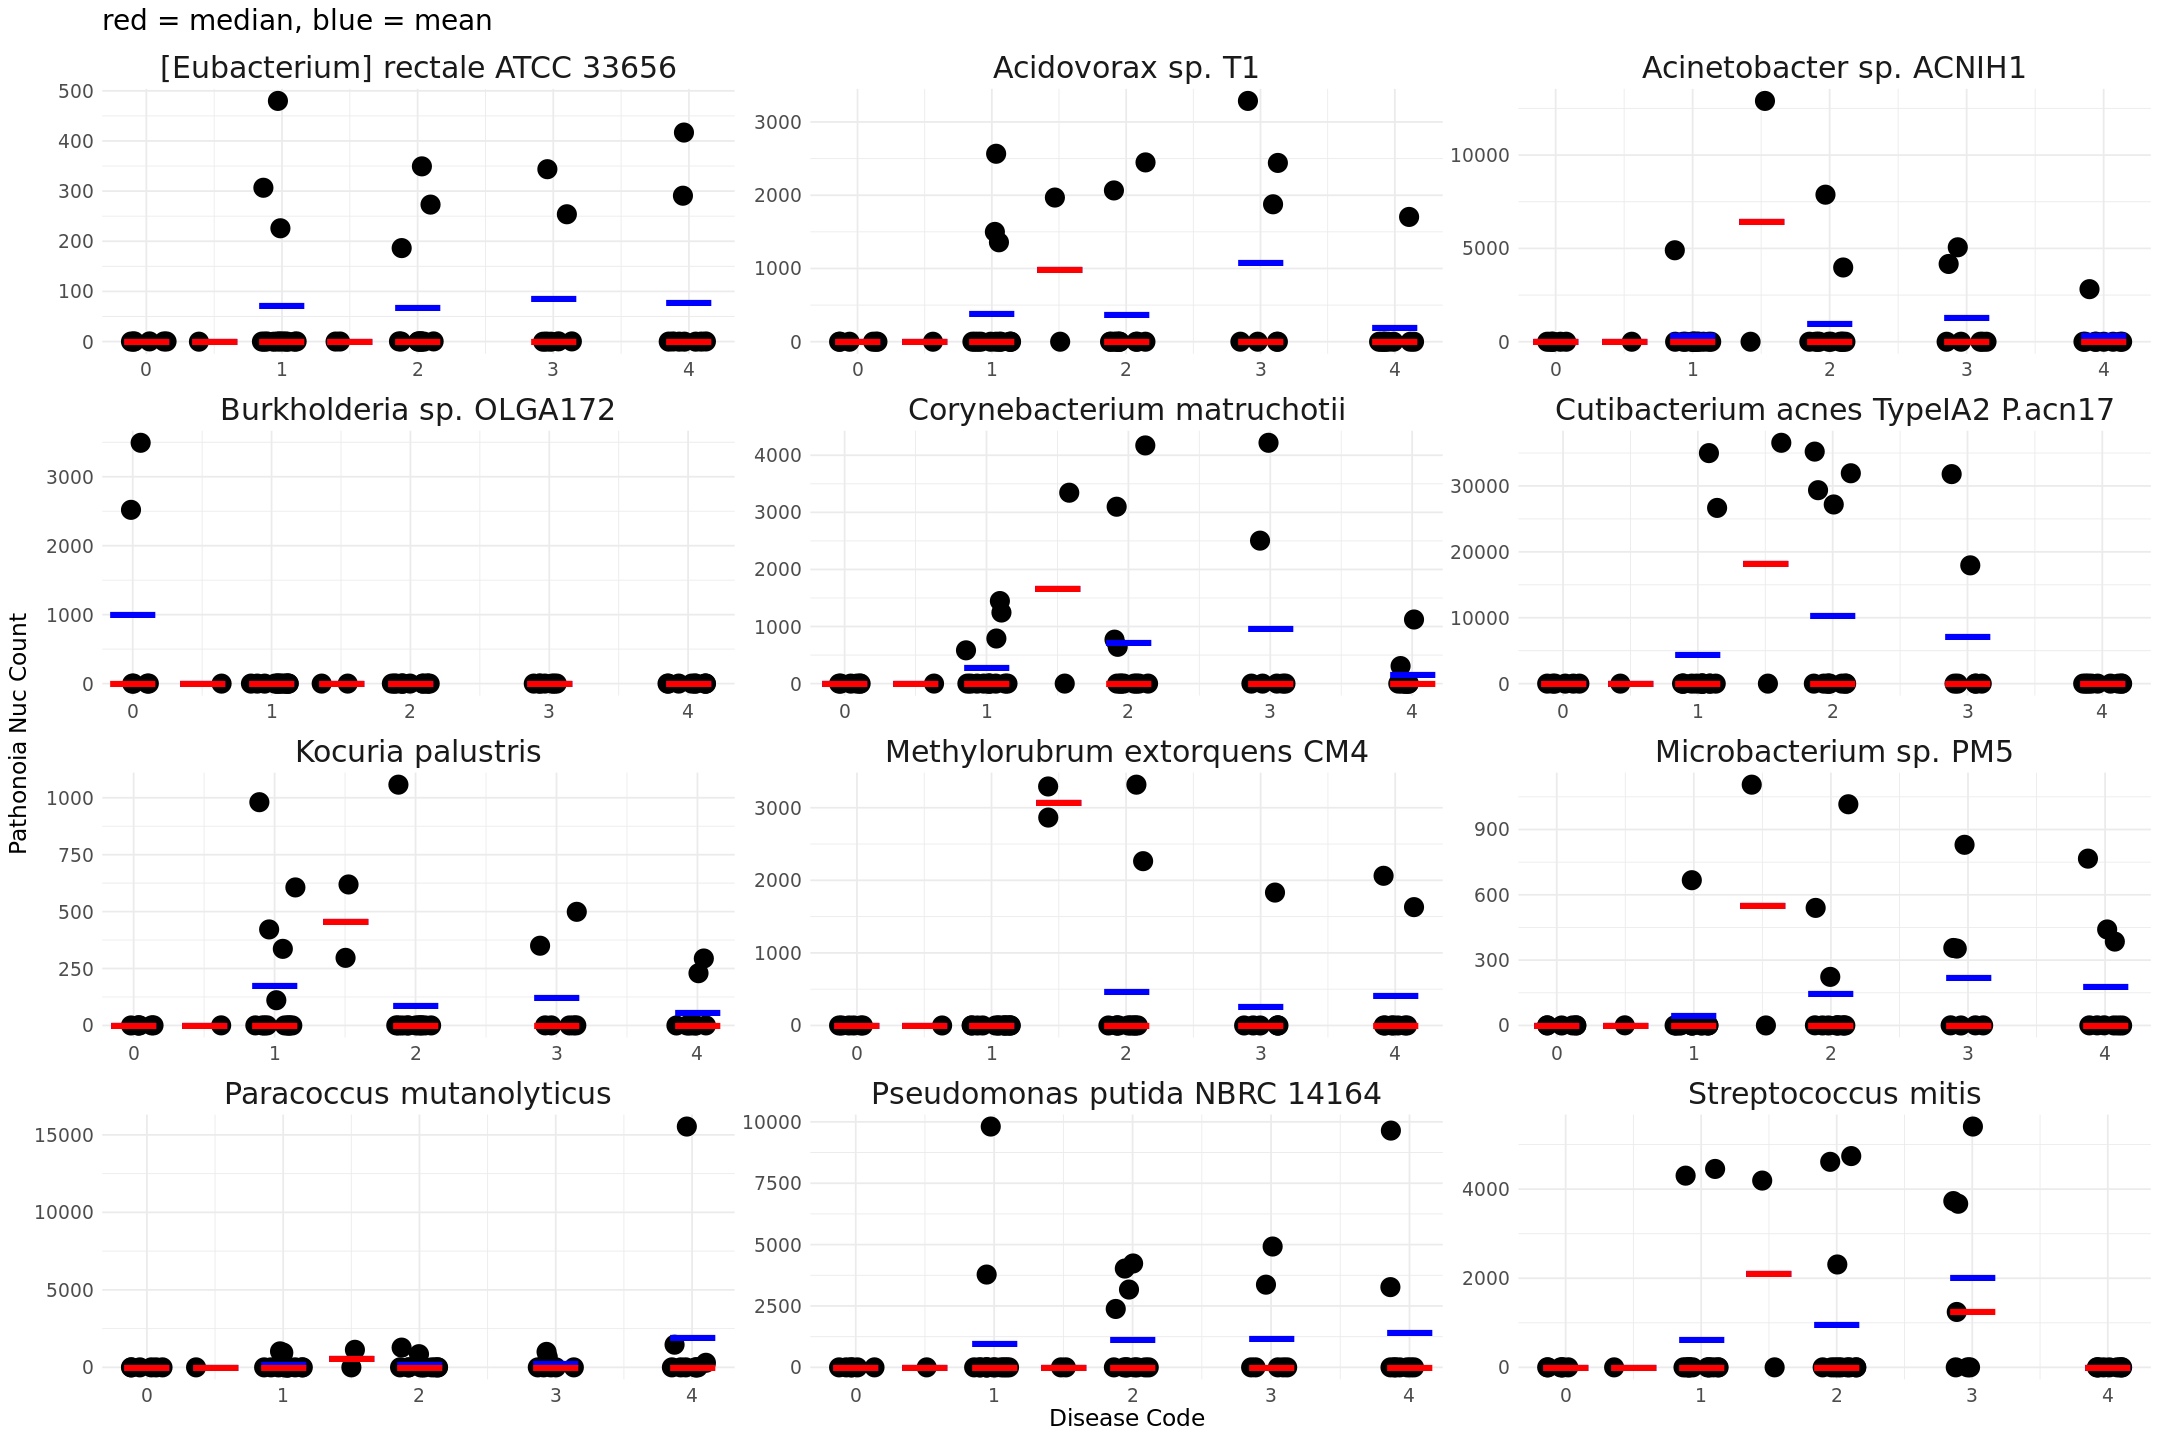

In [19]:
options(repr.plot.width=18, repr.plot.height=12)
samples = rownames(metadata_of_interest)
t = counts[rownames(r[1:12,]),samples] 
t$organism = r[1:12,"species_name"]
t = gather(t, key = "sample", value = "expression", -organism)
t = cbind(t, cc = metadata_of_interest[t$sample,"fibrosis"])
ggplot(t, aes(x = cc, y = expression)) + theme_minimal() + 
    geom_jitter(width = 0.15, size=5) +
    stat_summary(fun=mean, geom="point", shape=95, size=18, color="blue") + 
    stat_summary(fun=median, geom="point", shape=95, size=18, color="red") +
    theme(text = element_text(size=14), strip.text = element_text(size=18))+ 
    facet_wrap(facets = "organism", scales = "free", ncol=3) + 
    ggtitle(paste("red = median, blue = mean")) + xlab("Disease Code") + ylab("Pathonoia Nuc Count")


In [20]:
r = cbind(r, posi_samples = rowSums(counts[rownames(r),]>0))
r$log10_padj=-log10(r$padj)

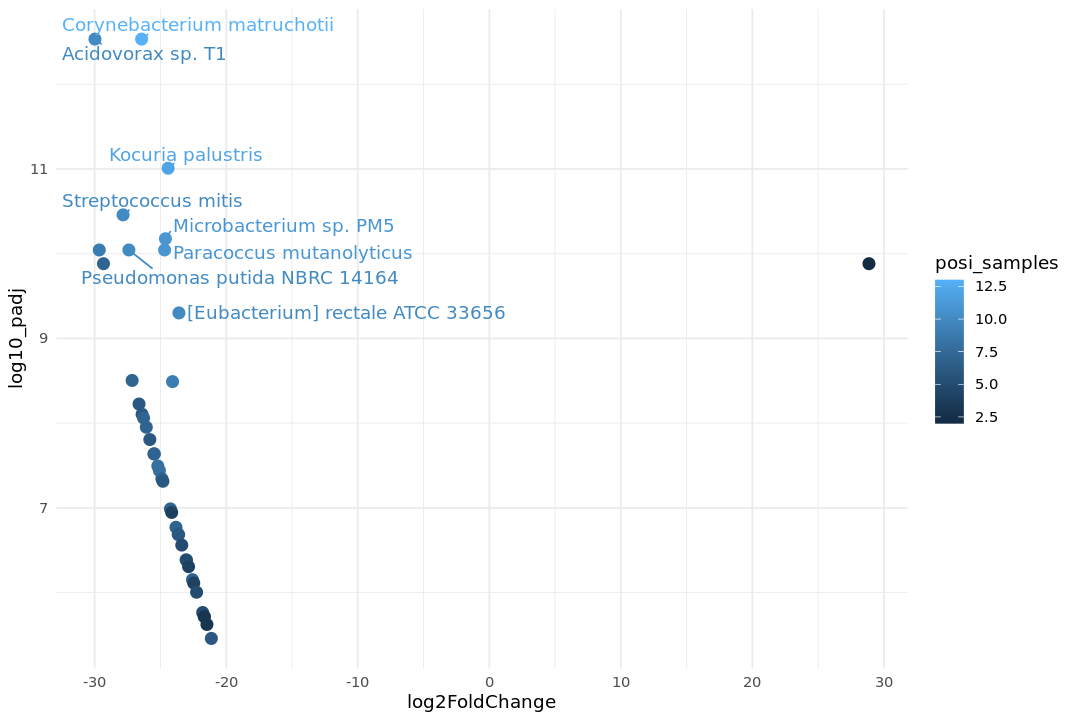

In [21]:
options(repr.plot.width=9, repr.plot.height=6)
ggplot(r, aes(log2FoldChange, log10_padj, color= posi_samples, label=ifelse(posi_samples>9, as.character(species_name),""))) + geom_point(size=3) + theme_minimal() + geom_text_repel(min.segment.length = 0) 

## DE Transcriptome

In [23]:
genecounts = read.table(paste0(inputfolder,"/PSC_gene_count_summary.txt"), header = TRUE, row.names = 1)

In [24]:
genecounts = genecounts[,samples]
genecounts

,F12246,F12247,F12248,F12249,F12250,F12252,F12254,F12255,F12257,F12260,⋯,F12320,F12321,F12323,F12326,F12327,F12328,F12329,F12331,F12333,F12339
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000223972.5,0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,1,0,2,0,0
ENSG00000227232.5,35,19,26,50,42,25,21,25,41,71,⋯,35,32,37,18,32,94,24,38,12,86
ENSG00000278267.1,3,0,2,5,6,1,0,0,2,5,⋯,0,3,6,0,0,9,0,4,2,13
ENSG00000243485.4,0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000268020.3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000240361.1,0,0,0,0,0,1,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000186092.4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000238009.6,0,0,0,0,0,3,0,0,0,4,⋯,1,0,0,0,0,0,0,1,0,0


In [25]:
#metadata$GENE_DE =  as.factor(t(counts["43768",rownames(metadata)] > 0)) 19 genes
#metadata$GENE_DE =  as.factor(t(counts["1858609",rownames(metadata)] > 0)) # 0 genes
metadata$GENE_DE =  as.factor(t(counts["71999",rownames(metadata)] > 0)) # 0 genes

samples_gde = rownames(metadata[metadata$fibrosis >= 1,])
metadata_gde = metadata[samples_gde,]
genecounts = genecounts[,samples_gde]

In [26]:
dds_g <- DESeqDataSetFromMatrix(countData = genecounts,
                              colData = metadata_gde,
                              design= ~ GENE_DE)
dds_g <- DESeq(dds_g)
resultsNames(dds_g) 

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 485 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"             "GENE_DE_TRUE_vs_FALSE"

In [27]:
gderes = as.data.frame(results(dds_g, name=resultsNames(dds_g)[2]))
gr = gderes[gderes$padj<0.05 & !is.na(gderes$padj),]
gr

baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [28]:
upregulated_genes = sapply(strsplit(rownames(gr[gr$log2FoldChange > 0,]), ".", fixed=T), function(x) x[1])
downregulated_genes = sapply(strsplit(rownames(gr[gr$log2FoldChange < 0,]), ".", fixed=T), function(x) x[1])
regulated_genes = sapply(strsplit(rownames(gr), ".", fixed=T), function(x) x[1])
downregulated_genes

list()

In [29]:
length(regulated_genes)

[1] 0

## Gene Ontology Analysis with WebGestalt

In [124]:
#functions for new WebGestaltR version! old ones available in v2
WebGes_BioProc <- function(genes, projectname){
    WebGestaltR(enrichMethod="ORA", organism="hsapiens",
    enrichDatabase="geneontology_Biological_Process",
    interestGene=genes,interestGeneType="ensembl_gene_id",referenceGeneType="genesymbol",
    referenceSet="genome_protein-coding", minNum=5, maxNum=2000,
    fdrMethod="BH",sigMethod="fdr",fdrThr=0.05,topThr=10,reportNum=20,perNum=1000,
    nThreads=64,
    isOutput=TRUE,outputDirectory="GO_results/GO_Analysis_biolProcess_FDR05",projectName=projectname,
    dagColor="continuous",hostName="http://www.webgestalt.org/")
}

WebGes_MolFun <- function(genes, projectname){
    WebGestaltR(enrichMethod="ORA", organism="hsapiens",
    enrichDatabase="geneontology_Molecular_Function",
    interestGene=genes,interestGeneType="ensembl_gene_id",referenceGeneType="genesymbol",
    referenceSet="genome_protein-coding", minNum=5, maxNum=2000,
    fdrMethod="BH",sigMethod="fdr",fdrThr=0.05,topThr=10,reportNum=20,perNum=1000,
    nThreads=64,
    isOutput=TRUE,outputDirectory="GO_results/GO_Analysis_molFunction_FDR05",projectName=projectname,
    dagColor="continuous",hostName="http://www.webgestalt.org/")
}



In [129]:
WebGes_BioProc(upregulated_genes, "fibrosis_71999_upDEgenes")
WebGes_BioProc(downregulated_genes, "fibrosis_71999_downDEgenes")
WebGes_BioProc(regulated_genes, "fibrosis_71999_DEgenes")
WebGes_MolFun(upregulated_genes, "fibrosis_71999_upDEgenes")
WebGes_MolFun(downregulated_genes, "fibrosis_71999_downDEgenes")
WebGes_MolFun(regulated_genes, "fibrosis_71999_DEgenes")

Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...


Warning message in oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum, :
“No significant gene set is identified based on FDR 0.05!”


NULL

### Dataset Information

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



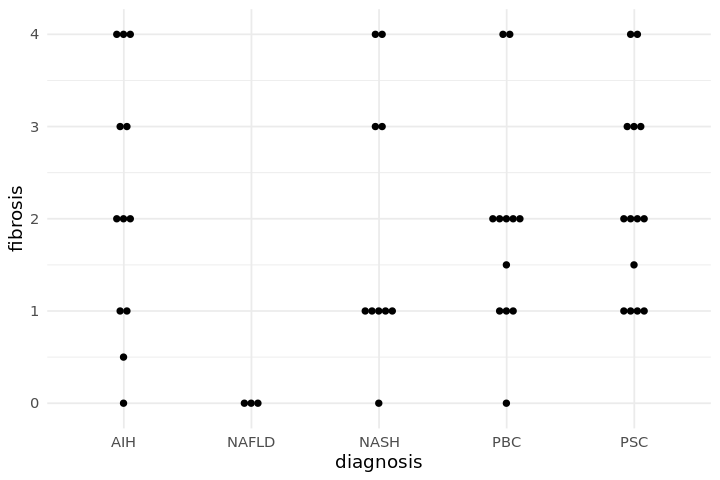

In [30]:
options(repr.plot.width=6, repr.plot.height=4)
ggplot(data = data.frame(metadata[c("diagnosis","fibrosis")]), aes(x=diagnosis, y=fibrosis)) + geom_dotplot(binaxis='y', stackdir='center', stackratio=1.1, dotsize=0.5) + theme_minimal()